# Augmented Reality System for Tourists in Oslo

Our jupyter notebook will use harris and sift algorithms to recognize a historic building in Oslo from an image.

We first find about 5 photos of each building, varying the brightness, angle etc. on google images, which form our database. And then a test photo for each building.

We calculate the descriptors of each image we store using the two algorithms.

Then, for each photo in the test folder, we calculate the number of matches with each photo in the database. The building with the most matches will therefore be the one on the test photo. 



In [2]:
import os
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import SIFT, match_descriptors, plot_matched_features
from skimage import transform
import cv2
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from pathlib import Path
import pandas as pd

# Harris method

### Preprocessing part

We first want to preprocess each photo we grey them and normalize them so that all images are processed from similar information

In [3]:
def preprocess_image(img_path, target_size=None, sigma=1):
    """
    Standard preprocessing:
    - grayscale
    - resize (optional)
    - normalize (zero mean, unit variance)
    - gaussian smoothing
    """
    im = np.array(Image.open(img_path).convert('L'), dtype=np.float32)
    if target_size:
        im = np.array(Image.fromarray(im).resize(target_size, Image.BICUBIC), dtype=np.float32)
    im = (im - np.mean(im)) / (np.std(im) + 1e-8)
    return gaussian_filter(im, sigma=sigma)

The next function are from the Chapter 2 of the book. They build the basis of the harris method

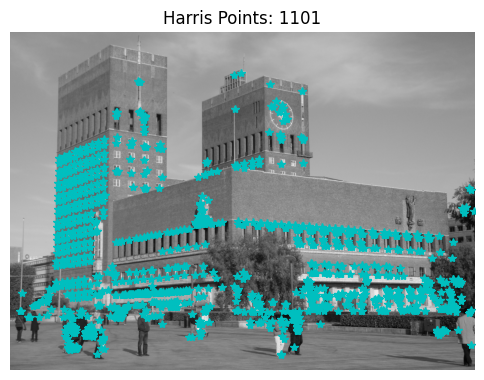

In [4]:
def compute_harris_response(im, sigma=3):
    """ Harris corner response. """
    imx = np.zeros_like(im)
    imy = np.zeros_like(im)
    gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    gaussian_filter(im, (sigma, sigma), (1, 0), imy)

    Wxx = gaussian_filter(imx * imx, sigma)
    Wxy = gaussian_filter(imx * imy, sigma)
    Wyy = gaussian_filter(imy * imy, sigma)

    Wdet = Wxx * Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return Wdet / (Wtr + 1e-8)


def get_harris_points(harrisim, min_dist=10, threshold=0.1):
    """ Extract Harris points above threshold with min distance. """
    coords = np.array((harrisim > harrisim.max() * threshold).nonzero()).T
    values = harrisim[coords[:, 0], coords[:, 1]]
    index = np.argsort(values)[::-1]  # tri décroissant

    allowed = np.zeros(harrisim.shape, dtype=bool)
    allowed[min_dist:-min_dist, min_dist:-min_dist] = True

    selected = []
    for i in index:
        y, x = coords[i]
        if allowed[y, x]:
            selected.append((y, x))
            allowed[y - min_dist:y + min_dist + 1, x - min_dist:x + min_dist + 1] = False
    return selected


def get_descriptors(image, coords, wid=5):
    """ Extract patch descriptors around each point. """
    desc = []
    for y, x in coords:
        patch = image[y - wid:y + wid + 1, x - wid:x + wid + 1]
        if patch.shape == (2 * wid + 1, 2 * wid + 1):  # ignore borders
            desc.append(patch.flatten())
    return np.array(desc)


def plot_harris_points(image, coords):
    plt.figure(figsize=(6, 6))
    plt.gray()
    plt.imshow(image)
    if coords:
        plt.plot([x for _, x in coords], [y for y, _ in coords], 'c*')
    plt.title(f"Harris Points: {len(coords)}")
    plt.axis('off')
    plt.show()

wid=5
harris_threshold = 0.2
im = preprocess_image("data/images/city_hall/city_hall1.jpg")
harrisim = compute_harris_response(im)
coords = get_harris_points(harrisim, min_dist=wid + 1, threshold=harris_threshold)
descriptors = get_descriptors(im, coords, wid)

plot_harris_points(im, coords)

We are now going to use these method to create a database. 

Each photo will be computed and we will put in a txt file the descriptors to being able to calculate matches without compute the descriptors every round. 

In [5]:
def preprocess_harris_dataset(data_dir, feature_dir, harris_threshold=0.3, wid=5):
    """ Preprocess a dataset of images to extract and save Harris features. """
    os.makedirs(feature_dir, exist_ok=True)

    for landmark in os.listdir(data_dir):
        landmark_path = os.path.join(data_dir, landmark)
        if not os.path.isdir(landmark_path):
            continue

        out_path = os.path.join(feature_dir, landmark)
        os.makedirs(out_path, exist_ok=True)

        for img_name in os.listdir(landmark_path):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            img_path = os.path.join(landmark_path, img_name)
            im = preprocess_image(img_path)
            harrisim = compute_harris_response(im)
            coords = get_harris_points(harrisim, min_dist=wid + 1, threshold=harris_threshold)
            descriptors = get_descriptors(im, coords, wid)


            out_file = os.path.join(out_path, img_name.rsplit('.', 1)[0] + '.txt')
            with open(out_file, 'w') as f:
                for c, d in zip(coords, descriptors):
                    line = ','.join(map(str, [c[0], c[1]] + list(d)))
                    f.write(line + '\n')

            print(f"Processed {img_name} ({landmark}), {len(coords)} points.")

def load_features(feature_dir):
    """ Load coords + descriptors from txt files. """
    features = {}
    for landmark in os.listdir(feature_dir):
        l_path = os.path.join(feature_dir, landmark)
        if not os.path.isdir(l_path):
            continue
        features[landmark] = {}
        for f in os.listdir(l_path):
            if not f.endswith('.txt'):
                continue
            coords, desc = [], []
            with open(os.path.join(l_path, f)) as file:
                for line in file:
                    vals = list(map(float, line.strip().split(',')))
                    coords.append([int(vals[0]), int(vals[1])])
                    desc.append(np.array(vals[2:]))
            features[landmark][f] = (coords, np.array(desc))
    return features

### Matching part

We will try to match two photos with the matching function from the book also on chapter 2

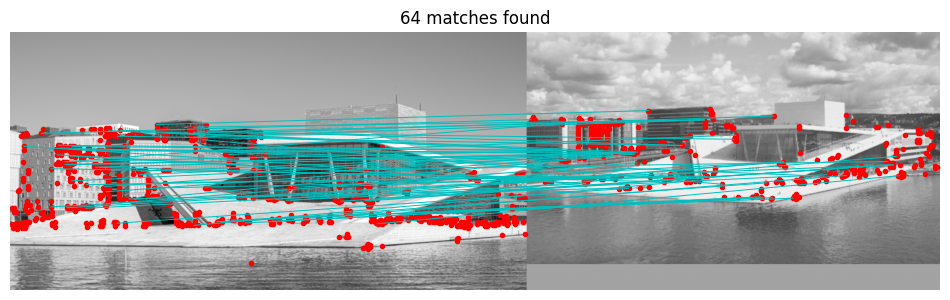

In [6]:
def match(desc1, desc2, locs1, locs2, ncc_thresh=0.6, dist_thresh=200, ratio=0.8):
    """ Match descriptors using NCC with distance & ratio tests. """
    matches = []
    n = desc1.shape[1]

    for i, d1 in enumerate(desc1):
        d1n = (d1 - np.mean(d1)) / (np.std(d1) + 1e-8)
        scores = []

        for j, d2 in enumerate(desc2):
            if np.linalg.norm(np.array(locs1[i]) - np.array(locs2[j])) > dist_thresh:
                continue
            d2n = (d2 - np.mean(d2)) / (np.std(d2) + 1e-8)
            ncc = np.sum(d1n * d2n) / (n - 1)
            if ncc > ncc_thresh:
                scores.append((j, 1 - ncc))

        if len(scores) >= 2:
            scores.sort(key=lambda x: x[1])
            best, second = scores[:2]
            if best[1] / (second[1] + 1e-8) < ratio:
                matches.append((i, best[0]))

    return matches


def plot_image_matches(img1_path, img2_path, ncc_thresh=0.6, harris_threshold=0.3, wid=5, dist_thresh=200, ratio=0.8):
    """
    Show matches between two images using Harris corners and NCC.
    """
    # Prétraitement
    im1 = preprocess_image(img1_path)
    im2 = preprocess_image(img2_path)

    # Harris + descripteurs
    harrisim1 = compute_harris_response(im1)
    harrisim2 = compute_harris_response(im2)
    coords1 = get_harris_points(harrisim1, min_dist=wid + 1, threshold=harris_threshold)
    coords2 = get_harris_points(harrisim2, min_dist=wid + 1, threshold=harris_threshold)
    desc1 = get_descriptors(im1, coords1, wid)
    desc2 = get_descriptors(im2, coords2, wid)

    # Match
    matches = match(desc1, desc2, coords1, coords2,
                    ncc_thresh=ncc_thresh, dist_thresh=dist_thresh, ratio=ratio)

    # Plot côte à côte
    plt.figure(figsize=(12, 6))
    plt.gray()

    # Concaténer horizontalement
    h1, w1 = im1.shape
    h2, w2 = im2.shape
    h = max(h1, h2)
    concat_img = np.zeros((h, w1 + w2))
    concat_img[:h1, :w1] = im1
    concat_img[:h2, w1:w1 + w2] = im2
    plt.imshow(concat_img)

    # Points Harris
    for y, x in coords1:
        plt.plot(x, y, 'ro', markersize=3)
    for y, x in coords2:
        plt.plot(x + w1, y, 'ro', markersize=3)

    # Lignes de correspondance
    for i, j in matches:
        y1, x1 = coords1[i]
        y2, x2 = coords2[j]
        plt.plot([x1, x2 + w1], [y1, y2], 'c-', linewidth=0.7)

    plt.title(f"{len(matches)} matches found")
    plt.axis('off')
    plt.show()

    return matches


ncc_thresh = 0.7
ratio = 0.7
dist_thresh = 200
harris_threshold = 0.2

img1 = r"data\images\opera\opera1.jpg"
img2 = r"data\images\opera\opera2.jpg"
matches = plot_image_matches(img1, img2, ncc_thresh=ncc_thresh, ratio=ratio, dist_thresh=dist_thresh,harris_threshold=harris_threshold, wid=5)


### Classifying Part

As the goal is to classify a new image we will now take the new image and compare it to every image in our database. 

The one with the most matches will be use to define the new image. 

New Image descriptors: 


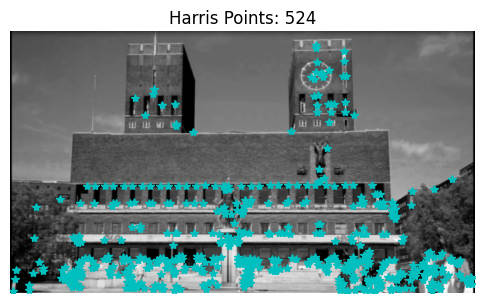

Comparing city_hall1.txt (city_hall): 23 matches
Comparing city_hall2.txt (city_hall): 42 matches
Comparing city_hall3.txt (city_hall): 0 matches
Comparing city_hall4.txt (city_hall): 136 matches
Comparing fram1.txt (fram): 55 matches
Comparing fram2.txt (fram): 44 matches
Comparing fram3.txt (fram): 4 matches
Comparing fram4.txt (fram): 74 matches
Comparing opera1.txt (opera): 114 matches
Comparing opera2.txt (opera): 100 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 49 matches
Comparing opera5.txt (opera): 0 matches
Comparing palace1.txt (palace): 68 matches
Comparing palace2.txt (palace): 35 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 2 matches
Comparing palace5.txt (palace): 32 matches
Comparing vigeland1.txt (vigeland): 102 matches
Comparing vigeland2.txt (vigeland): 35 matches
Comparing vigeland3.txt (vigeland): 0 matches
Comparing vigeland4.txt (vigeland): 59 matches

city_hall_test is identified as city_hall


In [7]:
def classify_image(new_img_path, features, ncc_thresh=0.6, harris_threshold=0.2, wid=5, dist_thresh=500, ratio=0.8):
    im = preprocess_image(new_img_path)
    harrisim = compute_harris_response(im)
    coords_new = get_harris_points(harrisim, min_dist=wid + 1, threshold=harris_threshold)
    desc_new = get_descriptors(im, coords_new, wid)

    plot_harris_points(im, coords_new)

    best_score, best_landmark, best_image = -1, None, None
    for landmark, images in features.items():
        for img_name, (coords_ref, desc_ref) in images.items():
            if len(desc_ref) == 0 or len(desc_new) == 0:
                continue
            matches = match(desc_new, desc_ref, coords_new, coords_ref,
                            dist_thresh=dist_thresh, ratio=ratio, ncc_thresh=ncc_thresh)
            num = len(matches)
            print(f"Comparing {img_name} ({landmark}): {num} matches")

            if num > best_score:
                best_score, best_landmark, best_image = num, landmark, img_name

    return best_landmark, best_image, best_score

data_dir = r"data\images"
feature_dir = r"data\features"

ncc_thresh = 0.7
ratio = 0.7
dist_thresh = 200
harris_threshold = 0.2

# decomment to preprocess the dataset only once
#preprocess_harris_dataset(data_dir, feature_dir, harris_threshold=harris_threshold, wid=5)

features = load_features(feature_dir)
print("New Image descriptors: ")
img_path=r"data\test\city_hall_test.jpg"
img_name="city_hall_test"
landmark, ref_img, score = classify_image(
        img_path, features,
        ncc_thresh=ncc_thresh,
        dist_thresh=dist_thresh,
        ratio=ratio,
        harris_threshold=harris_threshold,
        wid=wid
)
print(f"\n{img_name} is identified as {landmark}\nRef: {ref_img}, Matches: {score}")



To do it on every image of the test dataset run the below code (long computed time)

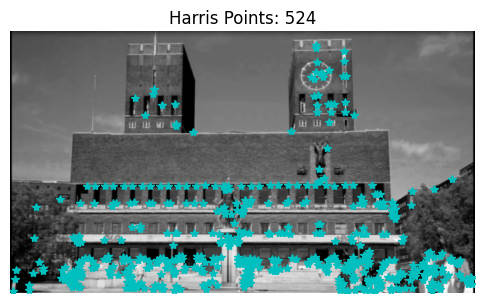

Comparing city_hall1.txt (city_hall): 23 matches
Comparing city_hall2.txt (city_hall): 42 matches
Comparing city_hall3.txt (city_hall): 0 matches
Comparing city_hall4.txt (city_hall): 136 matches
Comparing fram1.txt (fram): 55 matches
Comparing fram2.txt (fram): 44 matches
Comparing fram3.txt (fram): 4 matches
Comparing fram4.txt (fram): 74 matches
Comparing opera1.txt (opera): 114 matches
Comparing opera2.txt (opera): 100 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 49 matches
Comparing opera5.txt (opera): 0 matches
Comparing palace1.txt (palace): 68 matches
Comparing palace2.txt (palace): 35 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 2 matches
Comparing palace5.txt (palace): 32 matches
Comparing vigeland1.txt (vigeland): 102 matches
Comparing vigeland2.txt (vigeland): 35 matches
Comparing vigeland3.txt (vigeland): 0 matches
Comparing vigeland4.txt (vigeland): 59 matches
[city_hall_test.jpg] -> Landmark: city_hall

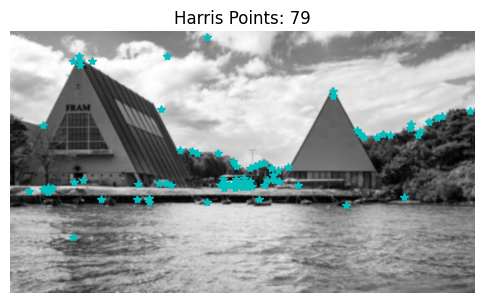

Comparing city_hall1.txt (city_hall): 0 matches
Comparing city_hall2.txt (city_hall): 5 matches
Comparing city_hall3.txt (city_hall): 1 matches
Comparing city_hall4.txt (city_hall): 4 matches
Comparing fram1.txt (fram): 10 matches
Comparing fram2.txt (fram): 1 matches
Comparing fram3.txt (fram): 0 matches
Comparing fram4.txt (fram): 16 matches
Comparing opera1.txt (opera): 0 matches
Comparing opera2.txt (opera): 2 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 0 matches
Comparing opera5.txt (opera): 0 matches
Comparing palace1.txt (palace): 0 matches
Comparing palace2.txt (palace): 0 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 7 matches
Comparing palace5.txt (palace): 13 matches
Comparing vigeland1.txt (vigeland): 0 matches
Comparing vigeland2.txt (vigeland): 14 matches
Comparing vigeland3.txt (vigeland): 0 matches
Comparing vigeland4.txt (vigeland): 7 matches
[fram_test.jpg] -> Landmark: fram, Ref: fram4.txt, Matches

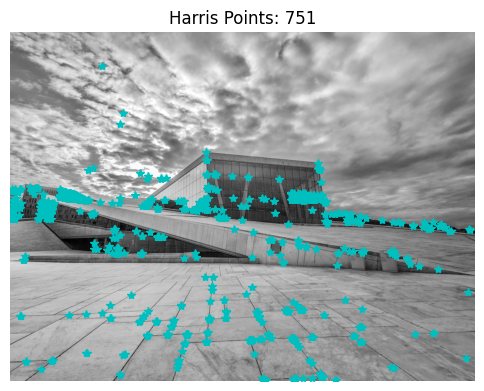

Comparing city_hall1.txt (city_hall): 20 matches
Comparing city_hall2.txt (city_hall): 0 matches
Comparing city_hall3.txt (city_hall): 0 matches
Comparing city_hall4.txt (city_hall): 0 matches
Comparing fram1.txt (fram): 0 matches
Comparing fram2.txt (fram): 0 matches
Comparing fram3.txt (fram): 6 matches
Comparing fram4.txt (fram): 0 matches
Comparing opera1.txt (opera): 0 matches
Comparing opera2.txt (opera): 0 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 0 matches
Comparing opera5.txt (opera): 8 matches
Comparing palace1.txt (palace): 1 matches
Comparing palace2.txt (palace): 0 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 0 matches
Comparing palace5.txt (palace): 0 matches
Comparing vigeland1.txt (vigeland): 0 matches
Comparing vigeland2.txt (vigeland): 0 matches
Comparing vigeland3.txt (vigeland): 21 matches
Comparing vigeland4.txt (vigeland): 0 matches
[opera_test.avif] -> Landmark: vigeland, Ref: vigeland3.txt,

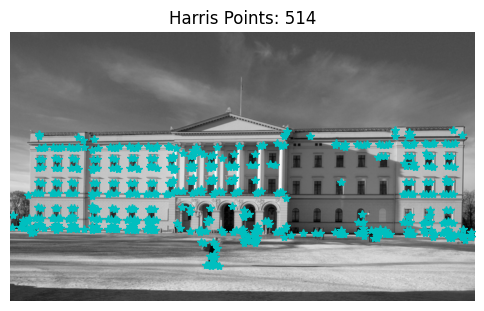

Comparing city_hall1.txt (city_hall): 2 matches
Comparing city_hall2.txt (city_hall): 47 matches
Comparing city_hall3.txt (city_hall): 1 matches
Comparing city_hall4.txt (city_hall): 101 matches
Comparing fram1.txt (fram): 81 matches
Comparing fram2.txt (fram): 51 matches
Comparing fram3.txt (fram): 0 matches
Comparing fram4.txt (fram): 61 matches
Comparing opera1.txt (opera): 81 matches
Comparing opera2.txt (opera): 72 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 67 matches
Comparing opera5.txt (opera): 0 matches
Comparing palace1.txt (palace): 30 matches
Comparing palace2.txt (palace): 14 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 16 matches
Comparing palace5.txt (palace): 62 matches
Comparing vigeland1.txt (vigeland): 43 matches
Comparing vigeland2.txt (vigeland): 71 matches
Comparing vigeland3.txt (vigeland): 0 matches
Comparing vigeland4.txt (vigeland): 84 matches
[palace_test.jpg] -> Landmark: city_hall, Ref:

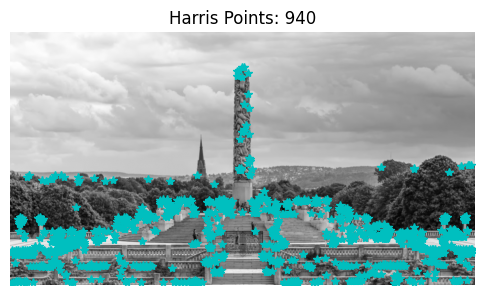

Comparing city_hall1.txt (city_hall): 29 matches
Comparing city_hall2.txt (city_hall): 1 matches
Comparing city_hall3.txt (city_hall): 0 matches
Comparing city_hall4.txt (city_hall): 34 matches
Comparing fram1.txt (fram): 0 matches
Comparing fram2.txt (fram): 0 matches
Comparing fram3.txt (fram): 44 matches
Comparing fram4.txt (fram): 8 matches
Comparing opera1.txt (opera): 69 matches
Comparing opera2.txt (opera): 5 matches
Comparing opera3.txt (opera): 0 matches
Comparing opera4.txt (opera): 3 matches
Comparing opera5.txt (opera): 0 matches
Comparing palace1.txt (palace): 107 matches
Comparing palace2.txt (palace): 94 matches
Comparing palace3.txt (palace): 0 matches
Comparing palace4.txt (palace): 0 matches
Comparing palace5.txt (palace): 1 matches
Comparing vigeland1.txt (vigeland): 142 matches
Comparing vigeland2.txt (vigeland): 0 matches
Comparing vigeland3.txt (vigeland): 7 matches
Comparing vigeland4.txt (vigeland): 5 matches
[vigeland_test.avif] -> Landmark: vigeland, Ref: vige

In [8]:
def classify_test_folder(test_dir, features, ncc_thresh=0.5, ratio=0.5, dist_thresh=200, harris_threshold=0.2, wid=5):
    """
    Parcourt toutes les images dans test_dir, applique la classification Harris
    et retourne un dictionnaire {nom_image: (landmark, ref_img, score)}.
    """
    results = {}

    for img_name in os.listdir(test_dir):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.avif')):
            continue

        img_path = os.path.join(test_dir, img_name)
        landmark, ref_img, score = classify_image(
            img_path, features,
            ncc_thresh=ncc_thresh,
            dist_thresh=dist_thresh,
            ratio=ratio,
            harris_threshold=harris_threshold,
            wid=wid
        )
        
        results[img_name] = (landmark, ref_img, score)
        print(f"[{img_name}] -> Landmark: {landmark}, Ref: {ref_img}, Matches: {score}")

    return results

test_dir = r"data\test"

ncc_thresh = 0.7
ratio = 0.7
dist_thresh = 200
harris_threshold = 0.2

results = classify_test_folder(
    test_dir, features,
    ncc_thresh=ncc_thresh,
    ratio=ratio,
    dist_thresh=dist_thresh,
    harris_threshold=harris_threshold,
    wid=5
)

# SIFT algorithm

## Pre-processing 
For this akgorithm, we keep the same preprocess method. Due to programs that take to much time, we decided to reduce all the images to (800x800) si it doesn't take 30 minutes to upload.

In [15]:
# Extract SIFT keypoints and descriptors
def extract_sift_features(image_filename):
    image = preprocess_image(image_filename, target_size = (800, 800))
    sift = SIFT()
    sift.detect_and_extract(image)
    return sift.keypoints, sift.descriptors

def load_base(dataset_dir = 'data/images'):
    dataset_paths = sorted(Path(dataset_dir).rglob("*"))
    records = []

    for ref_path in dataset_paths:
        print(f"Currently working on {ref_path}")
        
        if ref_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".avif"]:
            continue
            
        img_ref = np.array(Image.open(str(ref_path)).convert('L'), dtype=np.float32)
        keypoints_ref, descriptors_ref = extract_sift_features(str(ref_path))

        if len(keypoints_ref) == 0:
            print(f" Skipped {ref_path.name} due to missing keypoints")
            continue

        record = {
            "filename" : ref_path.name,
            "path": str(ref_path),
            "num_keypoints": len(keypoints_ref),
            "keypoints": keypoints_ref,
            "descriptors": descriptors_ref,
            "image_shape": img_ref.shape,
            "image": img_ref,
        }
        records.append(record)

    df = pd.DataFrame(records)
    return df

Thanks to the code below, we save necessary informations from all the pictures of our dataset.

In [16]:
data = load_base()

Currently working on data\images\city_hall
Currently working on data\images\city_hall\city_hall1.jpg
Currently working on data\images\city_hall\city_hall2.jpg
Currently working on data\images\city_hall\city_hall3.jpeg
Currently working on data\images\city_hall\city_hall4.jpg
Currently working on data\images\fram
Currently working on data\images\fram\fram1.png
Currently working on data\images\fram\fram2.jpeg
Currently working on data\images\fram\fram3.jpeg
Currently working on data\images\fram\fram4.jpg
Currently working on data\images\fram\fram5.avif
Currently working on data\images\opera
Currently working on data\images\opera\opera1.jpg
Currently working on data\images\opera\opera2.jpg
Currently working on data\images\opera\opera3.jpeg
Currently working on data\images\opera\opera4.jpg
Currently working on data\images\opera\opera5.jpg
Currently working on data\images\palace
Currently working on data\images\palace\palace1.jpg
Currently working on data\images\palace\palace2.jpeg
Currentl

We decided to not show images when there are not matching because it will take more computing power. Plots will be made further ahead, when all the pictures will be compared.

### Compute SIFT algorithm

To compute the SIFT model, we decided to use the homography matrix : she is used to see how points in a first picture is projected to another. It counts the different angles, and place where the pictures were taken. 

With this tools, we also compute the accuracy of a model. Which means we compare the matching points that wzere given to verify if there are really corresponding with each others.

In [11]:
def create_homography(keypoints1, keypoints2, descriptors1, descriptors2):
    """
    Create a homography matrix from source points to destination points.
    """
    # Convert descriptors to float32 if needed
    descriptors1 = descriptors1.astype(np.float32)
    descriptors2 = descriptors2.astype(np.float32)

    # Match descriptors using BFMatcher + Lowe ratio test
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    raw_matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in raw_matches:
        if m.distance < 0.6 * n.distance:
            good_matches.append((m.queryIdx, m.trainIdx))

    if len(good_matches) < 4:
        print(f"Not enough matches to estimate homography: {len(good_matches)} found")
        return None, None

    matches = np.array(good_matches, dtype=int)
    
    if matches is None:
        print("No matches found.")
        return None, None
    
    src = keypoints1[matches[:, 0]]  # points from image 1
    dst = keypoints2[matches[:, 1]]  # corresponding points in image 2

    model_robust, inliers = ransac(
        (src, dst),
        ProjectiveTransform,
        min_samples=4,
        residual_threshold=2,
        max_trials=1000
    )
    H = model_robust.params 
    return H, matches



# Compute matching accuracy using optional homography
def compute_matching_accuracy(keypoints1, keypoints2, matches, homography=None, threshold=5):
    """
    Compute the matching accuracy based on a homography.
    If no homography is provided, only the number of matches is printed.
    """
    if homography is None:
        print(f"No homographt matrix to work with")
        return None

    if matches is None or len(matches) == 0:
        print("No matches to evaluate.")
        return 0

    correct = 0
    for i, j in matches:
        pt1 = np.array([*keypoints1[i], 1.0])  # homogeneous coordinates
        projected = homography @ pt1
        projected /= projected[2]  # normalize

        pt2 = keypoints2[j]
        error = np.linalg.norm(projected[:2] - pt2)

        if error < threshold:
            correct += 1

    accuracy = correct / len(matches) if matches.size > 0 else 0
    return accuracy

Since some of our pictures have similarities, we can now plot them to see the different matching points. We will do it after defining the more similar picture to the test as an example.

In [12]:
# Visualize the matches
def match_and_plot(img1, img2, keypoints1, descriptors1, keypoints2, descriptors2, title):
    matches = match_descriptors(descriptors1, descriptors2, max_ratio=0.6, cross_check=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    plt.gray()
    plot_matched_features(image0=img1, image1=img2, 
                          keypoints0=keypoints1, keypoints1=keypoints2,
                          matches=matches, ax=ax, 
                          keypoints_color='cyan',
                          only_matches=True)
    ax.axis('off')
    ax.set_title(title)
    plt.show()
    return matches

To compare the accuracy between the test image and the the others, we created two methods : 

- comparison_small : compare the picture to picture of the same place ;
- comparison_all : compare a test image to all the images of the dataset.

In [13]:
def comparison_small(ref_path):
    filename = os.path.basename(ref_path)  # "city_hall_test.jpg"
    folder_name = filename.split('_')[0]  # "city_hall"

    # Extraire le préfixe du nom de fichier (avant le premier "_")
    data["folder_name"] = data["filename"].str.split("_").str[0]

    # Filtrer les lignes correspondant au dossier "city_hall"
    df_element = data[data["path"].str.contains(folder_name)]

    img_ref = np.array(Image.open(str(ref_path)).convert('L'), dtype=np.float32)
    keypoints_ref, descriptors_ref = extract_sift_features(str(ref_path))

    for _, files in df_element.iterrows() : 
        H1, matches = create_homography(files["keypoints"], keypoints_ref, files["descriptors"], descriptors_ref)
        accuracy = compute_matching_accuracy(files['keypoints'], keypoints_ref, matches, H1)
        print(f'Accuracy between {ref_path} and {files['filename']} : {accuracy}')



In [17]:
comparison_small("data/test/city_hall_test.jpg")
comparison_small("data/test/fram_test.jpg")
comparison_small("data/test/palace_test.jpg")
comparison_small("data/test/vigeland_test.avif")
# ----------------- Take more time ------------------
comparison_small("data/test/opera_test.avif")

Accuracy between data/test/city_hall_test.jpg and city_hall1.jpg : 0.5925925925925926
Not enough matches to estimate homography: 2 found
No homographt matrix to work with
Accuracy between data/test/city_hall_test.jpg and city_hall2.jpg : None
Not enough matches to estimate homography: 3 found
No homographt matrix to work with
Accuracy between data/test/city_hall_test.jpg and city_hall3.jpeg : None
Accuracy between data/test/city_hall_test.jpg and city_hall4.jpg : 0.6
Accuracy between data/test/fram_test.jpg and fram1.png : 0.6666666666666666
Accuracy between data/test/fram_test.jpg and fram2.jpeg : 1.0
Not enough matches to estimate homography: 0 found
No homographt matrix to work with
Accuracy between data/test/fram_test.jpg and fram3.jpeg : None
Not enough matches to estimate homography: 0 found
No homographt matrix to work with
Accuracy between data/test/fram_test.jpg and fram4.jpg : None
Not enough matches to estimate homography: 3 found
No homographt matrix to work with
Accuracy b

c:\Users\emmar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Accuracy between data/test/vigeland_test.avif and vigeland2.jpg : 0.3076923076923077
Not enough matches to estimate homography: 1 found
No homographt matrix to work with
Accuracy between data/test/vigeland_test.avif and vigeland3.jpg : None
Accuracy between data/test/vigeland_test.avif and vigeland4.png : 0.4444444444444444
Not enough matches to estimate homography: 2 found
No homographt matrix to work with
Accuracy between data/test/opera_test.avif and opera1.jpg : None
Not enough matches to estimate homography: 1 found
No homographt matrix to work with
Accuracy between data/test/opera_test.avif and opera2.jpg : None
Not enough matches to estimate homography: 2 found
No homographt matrix to work with
Accuracy between data/test/opera_test.avif and opera3.jpeg : None
Not enough matches to estimate homography: 2 found
No homographt matrix to work with
Accuracy between data/test/opera_test.avif and opera4.jpg : None
Not enough matches to estimate homography: 1 found
No homographt matrix t

We will now represents the matching point of some of our pictures.

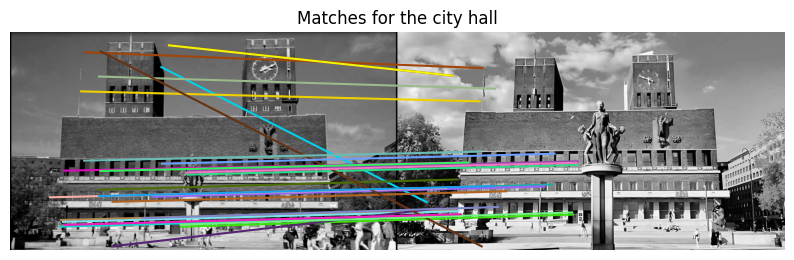

array([[  148,   207],
       [  332,  4393],
       [  522,   380],
       [  743,   477],
       [ 3835,  2734],
       [ 3965,  6903],
       [ 4354,  7037],
       [ 4590,  3635],
       [ 4677,  3711],
       [ 4693,  3762],
       [ 4789,  3823],
       [ 5706,  4717],
       [ 5745,  4768],
       [ 5918,  4865],
       [ 5934,  4866],
       [ 5938,  4880],
       [ 5947,  4893],
       [ 5957,  4861],
       [ 6517,  4665],
       [ 7249,   267],
       [ 7275,  5698],
       [ 7815,  2679],
       [ 7818,  6884],
       [ 8144,  7107],
       [ 8542,  7294],
       [ 9170,  7863],
       [ 9188,  7881],
       [ 9311,  7989],
       [ 9494,  8179],
       [10512,  4855],
       [10672,  8333]])

In [25]:
img_ref = np.array(Image.open('data/test/city_hall_test.jpg').convert('L'), dtype=np.float32)
keypoints_ref, descriptors_ref = extract_sift_features('data/test/city_hall_test.jpg')

data_im2 = df_element = data[data["path"].str.contains('city_hall4.jpg')]
descriptors2 = data_im2['descriptors'].iloc[0]
keypoints2 = data_im2['keypoints'].iloc[0]
img2 = data_im2['image'].iloc[0]

match_and_plot(img_ref, img2, keypoints_ref, descriptors_ref, keypoints2, descriptors2, "Matches for the city hall")

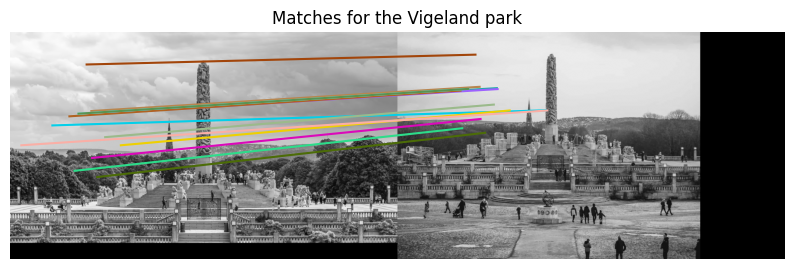

array([[   29,  9530],
       [ 1184,  1331],
       [ 2372,  1017],
       [ 3048,  1338],
       [ 4127,  1969],
       [ 5322,  2795],
       [ 5865,  3226],
       [ 6562,  7432],
       [ 6572,  7443],
       [ 7288,  7789],
       [ 8135,  9078],
       [ 8472,  9422],
       [ 8553,  9425],
       [10024, 11077]])

In [29]:
img_ref = np.array(Image.open('data/test/vigeland_test.avif').convert('L'), dtype=np.float32)
keypoints_ref, descriptors_ref = extract_sift_features('data/test/vigeland_test.avif')

data_im2 = df_element = data[data["path"].str.contains('vigeland1.jpg')]
descriptors2 = data_im2['descriptors'].iloc[0]
keypoints2 = data_im2['keypoints'].iloc[0]
img2 = data_im2['image'].iloc[0]

match_and_plot(img_ref, img2, keypoints_ref, descriptors_ref, keypoints2, descriptors2, "Matches for the Vigeland park")

Due to too much time to run and a memory error during the tests, the method comparison_all will not be taken in account.

In [ ]:
'''
def comparison_all (ref_path):
    ref_path = Path(ref_path)
    results_dict = []

    if ref_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".avif"]:
        pass
    
    print(f"Working on {ref_path}")

    img_ref = load_image(str(ref_path))
    keypoints_ref, descriptors_ref = extract_sift_features(str(ref_path))

    for _, files in data.iterrows():
        H1, matches = create_homography(files["keypoints"], keypoints_ref, files["descriptors"], descriptors_ref)
        accuracy = compute_matching_accuracy(files['keypoints'], keypoints_ref, matches, H1)
        if accuracy is not None:
            results_dict.append({
                "test_file": str(ref_path),
                "compared_file": files["path"],
                "accuracy": accuracy
            })
    return results_dict

results = comparison_all('../data/test/city_hall_test.jpg')
print(results)

'''